In [ ]:
import pandas as pd
from google.colab import files
uploaded = files.upload()


Saving HW1_Needed_Data_New.xlsx to HW1_Needed_Data_New.xlsx


In [ ]:
df = pd.read_excel("HW1_Needed_Data_New.xlsx")

In [ ]:
df['dealNumber'] = pd.to_numeric(df['代號'].str.replace('TX', '', regex=False))
df['dealDate'] = pd.to_datetime(df['日期'])
df['volume'] = pd.to_numeric(df['成交張數(量)'])
df['matDate'] = df['到期月']
df['open'] = df['開盤價']
df['high'] = df['最高價']
df['low'] = df['最低價']
df['close'] = df['收盤價']
df['daysLeft'] = pd.to_numeric(df['剩餘天數'])

In [ ]:
def extract_main(group):
  main = group.sort_values(by='volume', ascending=False).head(1).copy()
  main['主力'] = [1]
  return main
def extract_secondly_main(group):
  secondly_main = group.sort_values(by='volume', ascending=False).iloc[1:2].copy()
  secondly_main['次主力'] = [2]
  return secondly_main

**篩最大**

In [ ]:
main_df = df.groupby('dealDate').apply(extract_main)
secondly_main_df = df.groupby('dealDate').apply(extract_secondly_main)
main_df = main_df.reset_index(drop=True)
secondly_main_df = secondly_main_df.reset_index(drop=True)

/tmp/ipython-input-6-1060837504.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  main_df = df.groupby('dealDate').apply(extract_main)
/tmp/ipython-input-6-1060837504.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  secondly_main_df = df.groupby('dealDate').apply(extract_secondly_main)


**單純計算每日損益**

In [ ]:
without_rolling_df = main_df.copy()
without_rolling_df['pure_pnl'] = without_rolling_df['close'].pct_change()
without_rolling_df['cum_pnl'] = (without_rolling_df['pure_pnl']).fillna(0).cumsum()

**轉倉函數!**

In [ ]:
import pandas as pd
from google.colab import files
uploaded = files.upload()

Saving Top2_Contracts_ByVolume.xlsx to Top2_Contracts_ByVolume.xlsx


In [ ]:
df_rolling = pd.read_excel("Top2_Contracts_ByVolume.xlsx")

In [ ]:
import pandas as pd
import numpy as np
def rolling_strategy_with_cost_new(df_rolling, N):
    df = df_rolling.sort_values(by=["代號", "剩餘天數"], ascending=[True, False]).reset_index(drop=True)
    profit = []
    for i in range(len(df)):
        today_date = df.loc[i, "日期"]
        current_code = df.loc[i, "代號"]

        if df.loc[i, "剩餘天數"] > N:
            daily_return = df.loc[i, "報酬率"]

        elif df.loc[i, "剩餘天數"] <= N:
            next_contract_row = df[
                (df["日期"] == today_date) &
                (df["代號"] != current_code)]
            if not next_contract_row.empty:
                next_contract_row = next_contract_row.iloc[0]
                daily_return = (
                    next_contract_row["收盤價"] - df.loc[i, "收盤價"]
                ) / df.loc[i, "收盤價"]
            else:
                daily_return = np.nan
        else:
            daily_return = np.nan

        profit.append(daily_return*0.01)
    profit = pd.Series(profit)
    df["dealDates"] = pd.to_datetime(df["日期"])
    df["daily_return"] = profit.pct_change().fillna(0)
    df["cumulative_return"] = np.cumsum(pd.Series(profit).fillna(0))
    return df


In [ ]:
def rolling_strategy_with_cost_new2(df_rolling, N):
    df = df_rolling.sort_values(by=["日期", "成交量(合計)"], ascending=[True, False]).reset_index(drop=True)

    used_idx = []
    profit = []

    for date, group in df.groupby("日期"):
        if len(group) < 1:
            continue

        main = group.iloc[0]  # 主力
        main_idx = main.name

        if main["剩餘天數"] > N:
            profit.append(main["報酬率"] * 0.01)
            used_idx.append(main_idx)

        else:
            if len(group) >= 2:
                second = group.iloc[1]
                ret = (second["收盤價"] - main["收盤價"]) / main["收盤價"]
                profit.append(ret * 0.01)
                used_idx.extend([main_idx, second.name])
            else:
                profit.append(np.nan)
                used_idx.append(main_idx)

    df = df.loc[sorted(set(used_idx))].copy().reset_index(drop=True)

    profit = pd.Series(profit)
    df["dealDates"] = pd.to_datetime(df["日期"])
    df["daily_return"] = profit.pct_change().fillna(0)
    df["cumulative_return"] = np.cumsum(profit.fillna(0))

    return df


In [ ]:
def rolling_strategy_with_cost_new3(df_rolling, N):
    df = df_rolling.sort_values(by=["代號", "剩餘天數"], ascending=[True, False]).reset_index(drop=True)

    result = []
    for date, group in df.groupby("日期"):
        group = group.sort_values("成交量(合計)", ascending=False)
        main = group.iloc[0]  # 主力合約

        if main["剩餘天數"] > N:
            daily_return = main["報酬率"] * 0.01
        else:
            if len(group) > 1:
                second = group.iloc[1]
                daily_return = (second["收盤價"] - main["收盤價"]) / main["收盤價"] * 0.01
            else:
                daily_return = 0  # 沒轉成功 → 0 報酬

        result.append({
            "日期": date,
            "daily_return": daily_return,
        })

    # 建立 DataFrame
    df_result = pd.DataFrame(result)
    df_result["cumulative_return"] = (1 + df_result["daily_return"]).cumprod() - 1
    df_result["dealDate"] = pd.to_datetime(df_result["日期"])
    return df_result


In [ ]:
rolling_two_days = rolling_strategy_with_cost_new3(df_rolling, 2)
rolling_five_days = rolling_strategy_with_cost_new3(df_rolling, 5)


**畫圖**

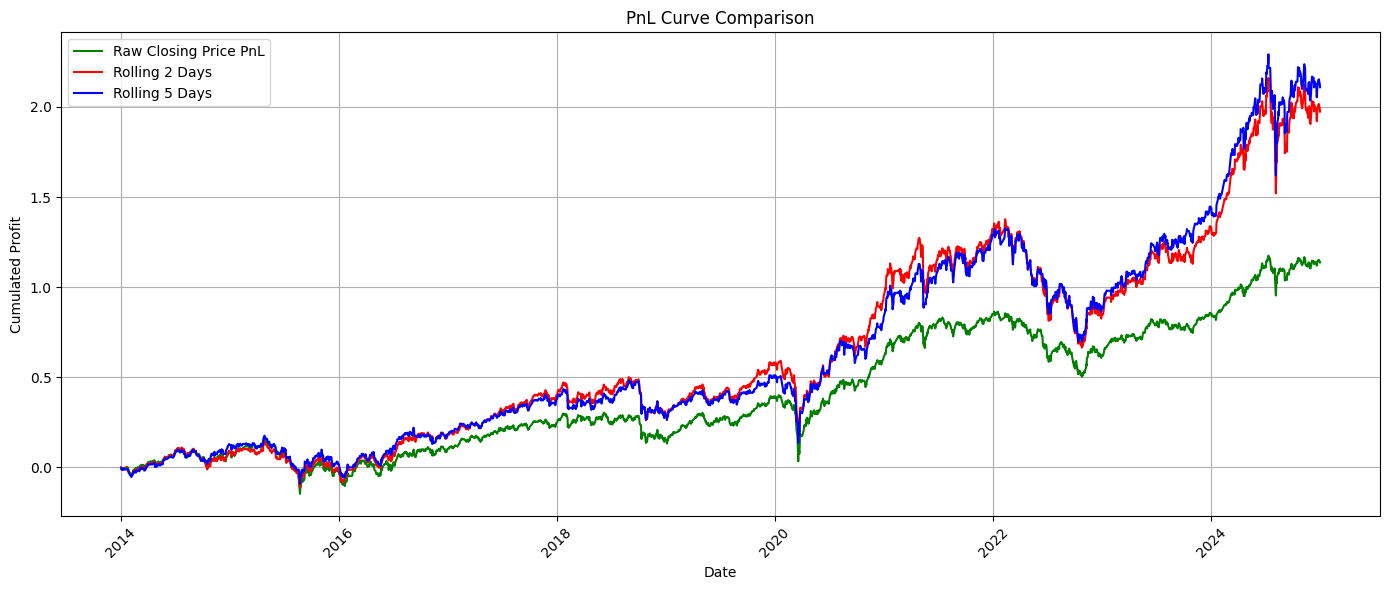

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(without_rolling_df['dealDate'], without_rolling_df['cum_pnl'], label='Raw Closing Price PnL', color='green')

plt.plot(rolling_two_days['dealDate'], rolling_two_days['cumulative_return'], label='Rolling 2 Days', color='red')
plt.plot(rolling_five_days['dealDate'], rolling_five_days['cumulative_return'], label='Rolling 5 Days', color='blue')


plt.xlabel('Date')
plt.ylabel('Cumulated Profit')
plt.title('PnL Curve Comparison')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
without_rolling_df

,代號,名稱,日期,到期月,開盤價,最高價,最低價,收盤價,每日結算價,報酬率,...,volume,matDate,open,high,low,close,daysLeft,主力,pure_pnl,cum_pnl
0,TX201401,台指 2014/01,2014/01/02,2014/01,8644.0,8649.0,8585.0,8618.0,8616,-0.1969,...,70152,2014/01,8644.0,8649.0,8585.0,8618.0,14,1,NaN,0.000000
1,TX201401,台指 2014/01,2014/01/03,2014/01,8595.0,8597.0,8530.0,8541.0,8542,-0.8589,...,82686,2014/01,8595.0,8597.0,8530.0,8541.0,13,1,-0.008935,-0.008935
2,TX201401,台指 2014/01,2014/01/06,2014/01,8539.0,8561.0,8503.0,8528.0,8526,-0.1873,...,81494,2014/01,8539.0,8561.0,8503.0,8528.0,10,1,-0.001522,-0.010457
3,TX201401,台指 2014/01,2014/01/07,2014/01,8528.0,8575.0,8525.0,8551.0,8550,0.2815,...,76176,2014/01,8528.0,8575.0,8525.0,8551.0,9,1,0.002697,-0.007760
4,TX201401,台指 2014/01,2014/01/08,2014/01,8556.0,8599.0,8550.0,8586.0,8584,0.3977,...,69802,2014/01,8556.0,8599.0,8550.0,8586.0,8,1,0.004093,-0.003667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2682,TX202501,臺指期 2025/01,2024/12/25,2025/01,23340.0,23349.0,23240.0,23329.0,23326,0.5388,...,32836,2025/01,23340.0,23349.0,23240.0,23329.0,22,1,0.004867,1.149339
2683,TX202501,臺指期 2025/01,2024/12/26,2025/01,23358.0,23380.0,23285.0,23326.0,23326,0.0000,...,27231,2025/01,23358.0,23380.0,23285.0,23326.0,21,1,-0.000129,1.149211
2684,TX202501,臺指期 2025/01,2024/12/27,2025/01,23194.0,23378.0,23148.0,23372.0,23372,0.1972,...,43009,2025/01,23194.0,23378.0,23148.0,23372.0,20,1,0.001972,1.151183
2685,TX202501,臺指期 2025/01,2024/12/30,2025/01,23202.0,23324.0,23154.0,23177.0,23171,-0.8600,...,37022,2025/01,23202.0,23324.0,23154.0,23177.0,17,1,-0.008343,1.142839


**計算各種轉倉時間損益**

In [ ]:
def calculate_metrics(df, return_col="daily_return", trading_days=252, rf=0.0):
    returns = df[return_col].fillna(0)
    cumulative = (1 + returns).cumprod()

    annual_return = (1 + returns.mean()) ** trading_days - 1
    annual_volatility = returns.std() * np.sqrt(trading_days)
    sharpe_ratio = (returns.mean() - rf / trading_days) / returns.std() * np.sqrt(trading_days)

    # Drawdown 計算
    peak = cumulative.cummax()
    drawdown = cumulative / peak - 1
    max_drawdown = drawdown.min() *-1

    # Recovery days
    recovery = 0
    max_recovery = 0
    for d in drawdown:
        if d < 0:
            recovery += 1
            max_recovery = max(max_recovery, recovery)
        else:
            recovery = 0

    return {
        "Annual Return ": annual_return ,
        "Annual Volatility": annual_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Max Drawdown": max_drawdown ,
        "Max Recovery Days": max_recovery
    }


In [ ]:
import pandas as pd

# 原本的 metrics dictionary
metrics = {
    "Raw Close PnL": calculate_metrics(without_rolling_df, return_col="pure_pnl"),
    "Rolling 2 Days": calculate_metrics(rolling_two_days, return_col="daily_return"),
    "Rolling 5 Days": calculate_metrics(rolling_five_days, return_col="daily_return")
}

# 將 dictionary 轉成 DataFrame 並轉置（策略為 row，指標為 column）
metrics_df = pd.DataFrame(metrics).T
display(metrics_df)


,Annual Return,Annual Volatility,Sharpe Ratio,Max Drawdown,Max Recovery Days
Raw Close PnL,0.112498,0.169225,0.630112,0.315079,508.0
Rolling 2 Days,0.121913,0.159847,0.719819,0.299733,478.0
Rolling 5 Days,0.125976,0.156314,0.759228,0.270352,423.0
